# MSGAI Lab 4 on Queueing Theory

## Course reminders

The goal of this lab is to experiment with different systems to handle pending jobs. To do so, we are going to simulate jobs arriving into a systems with a random arrival time and getting executed by the server. 

The objective is to find the systems with the lowest response time, i.e. the lowest value for the average time spent in the queue.

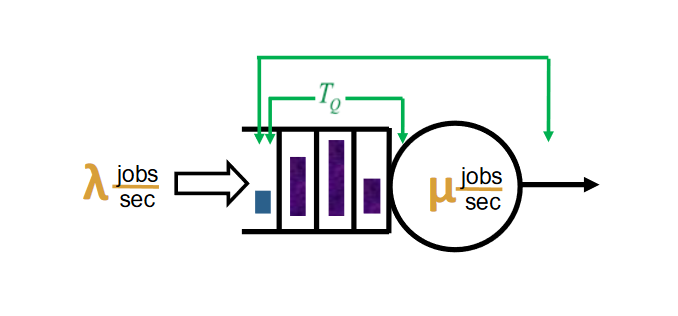

In [4]:
import concurrent
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy as sp
import queue
import time
import itertools
from threading import Thread
from tqdm.notebook import tqdm
from ipywidgets import IntProgress
from IPython.display import display

## Loading the dataset
Using the provided csv file we load the inter-arrival and service times.

In [5]:
df = pd.read_csv("./time.csv")
df

,inter_arrival_time,service_time
0,0.002829,0.000084
1,0.295002,0.000436
2,0.001777,0.091547
3,0.234186,0.003405
4,0.002912,0.000082
...,...,...
2995,0.002066,0.054290
2996,0.080122,0.000504
2997,0.085958,0.002821
2998,0.012676,0.000313


## Some fun things

Do a visual inspection to get a looksy into the data.

<Axes: ylabel='Frequency'>

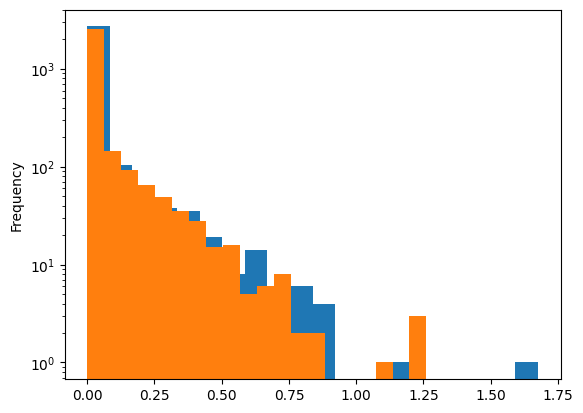

In [6]:
df["service_time"].plot.hist(logy=True, bins=20)
df["inter_arrival_time"].plot.hist(logy=True, bins=20)

## Calculating some stats

We continue by calculating some statistics from the data, needed to calculate theoretical values.

where τ is the mean service time (i.e. μ = 1/ τ  is the service rate), λ is the mean 
arrival rate,
ρ = λ / μ  is the utilization.

In [7]:
mean_arrival_time = np.mean(df.inter_arrival_time)
mean_service_time = tau = np.mean(df.service_time)

service_rate = mu = 1 / tau
arrival_rate = lamda = 1 / mean_arrival_time
utilization = rho = lamda / mu
print(f"Arrival rate:\t{lamda}")
print(f"Service rate:\t{mu}")
print(f"Utilization:\t{rho}")

Arrival rate:	21.473659022731887
Service rate:	26.48262987996106
Utilization:	0.8108582538843934


$c_a$ is the coefficient of variation for arrivals (that is the standard
deviation of arrival times divided by the mean arrival time) and $c_s$ is the coefficient of
variation for service times (that is the standard deviation of service times divided by the mean service time).

In [8]:
c_service = np.std(df.service_time) / mean_service_time
c_arrival = np.std(df.inter_arrival_time) / mean_arrival_time

print(f"Coefficient service:\t{c_service}")
print(f"Coefficient arrival:\t{c_arrival}")

Coefficient service:	2.866373224435675
Coefficient arrival:	2.4319743440548165


## Calculate theoretical values

Using our previous obtained values we calculate the theoretical values for M/M/1 and G/G/1 (Pareto) queueing system.

In [9]:
# For M/M/1 system, using provided formulae
expected_T = 1 / (mu - lamda)
expected_Tq = rho * expected_T

# For G/G/1
expected_Wq = (rho / (1 - rho)) * ((c_arrival ** 2 + c_service ** 2)/2) * tau

print("M/M/1 queue:")
print(f"E[T]\t {expected_T}")
print(f"E[Tq]\t {expected_Tq}")
print("\nG/G/1 queue:")
print(f"E[Wq]\t {expected_Wq}")

M/M/1 queue:
E[T]	 0.1996418083680313
E[Tq]	 0.16188120813562454

G/G/1 queue:
E[Wq]	 1.143738868581208


## Start the simulation

We create the `Server` class that will help us simulate the behavior of a queuing system. Jobs are received through the `submitter` method that 
passes them to the worker. For now, we define a Server that uses one queue and one worker.

In [ ]:
class Server:
    def __init__(self, df, n_workers=1):
        self.job_it = df.iterrows()
        self.max_count = df.shape[0]
        self.progress_bar = IntProgress(min=0, max=self.max_count) 
        self.job_queue = [queue.Queue() for _ in range(n_workers)]
        self.start_time = 0.
        self.running = False
        self.n_workers = n_workers
         
    def _receive(self):
        """
        We simulate the inter arrival time by waiting for a delay specified in the dataframe
        """
        job = next(self.job_it)
        receive_time = job[1].inter_arrival_time
        job_time = job[1].service_time
        time.sleep(receive_time)
        return job_time

    def _work(self, *args):
        """
        A placeholder method that simulates the task being executed by the server.
        """
        time.sleep(*args)

    def submitter(self):
        """
        Submitter function that submits job to the only worker queue between sleeps dictated
        by the input dataframe.
        We return the time each job was submitted to compute how long it remained in the queue 
        afterwards.
        """
        queue = self.job_queue[0]
        result = np.zeros(self.max_count)
        submitter_index = 0
        for _ in range(self.max_count):
            task = self._receive()
            queue.put(task)
            result[submitter_index] = time.time() - self.start_time
            submitter_index += 1
        print("Done submitting")
        self.running = False # Signal to worker to stop running after emptying the queue
        return (result,)

    def worker(self, idx=0):
        """
        A worker function to handle the jobs put in the queue. Each worker has its own queue.
        """
        queue = self.job_queue[idx]
        result = np.empty(self.max_count)
        result[:] = np.nan
        consumer_index = 0
        while self.running or not queue.empty():
            if not queue.empty():
                task = queue.get()
                queue.task_done()
                result[consumer_index] = time.time() - self.start_time
                consumer_index += 1
                self._work(task)
                self.progress_bar.value += 1  # signal to increment the progress bar
        print(f"done ({idx})")
        return result

    def run(self, save=True):
        """
        Method used to run the simulation. The submitter and every worker each get a separate thread.
        Note that due to python implementation the execution is not strictly concurrent, but we won't 
        bother with that here.
        """
        self.running = True
        display(self.progress_bar)
        self.start_time = time.time()
        
        # Start two concurrent threads, notice that worker is started before submitter
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future_workers = [executor.submit(self.worker, i) for i in range(self.n_workers)]
            future_submitter = executor.submit(self.submitter)
            submit_res = future_submitter.result()
            worker_res = [worker.result() for worker in future_workers]
        
        res = pd.DataFrame(list(zip(*submit_res, *worker_res)))
        if save:
            res.to_csv("outputs_seconds_tst.csv",  index=False)
        return res
        

In [11]:
server = Server(df)
result_df = server.run()

IntProgress(value=0, max=3000)

Done submitting
done (0)


Let's now compute the average waiting time. We compute the time spent in the queue such as: $$T_Q = T_\text{assigned} - T_\text{submitted}$$

In [12]:
result_df = pd.read_csv("outputs_seconds_tst.csv")
Wq = sum((result_df['1'] - result_df['0'])) / 3000
print(f"Average time spent in queue: {Wq:.3f}s")

Average time spent in queue: 0.870s


What can we conclude ?

## Several workers

We now move on to a setup where the server uses several workers. This mean we have to elaborate a strategy to dispatch the incoming jobs to the different workers.

First, let's generate some data corresponding to a Poisson Process to simplify our computation

In [13]:
rng = np.random.default_rng(seed=0xB0B)
n_samples = 3000

df = pd.DataFrame({
    'inter_arrival_time':rng.exponential(scale=0.075, size=n_samples),
    'service_time': rng.exponential(scale=0.2, size=n_samples)
})

Now let's experiment with the different load balancing policies.

### Round Robin

Write the code to submit jobs according to the Round Robin balancing (assign incoming tasks to each worker on a alternating pattern). Run the simulation and comment the results

In [14]:
class Server_RR(Server):
    def submitter(self):
        result = np.empty((self.n_workers, self.max_count))
        result[:] = np.nan  # NaN will enable us to easily see where we don't have any values later on

        
        ##### Your code goes here #####

        
        return tuple(result[i, :] for i in range(self.n_workers))
        

In [ ]:
server = Server_RR(df, n_workers=3)
results_df = server.run()

IntProgress(value=0, max=3000)

In [ ]:
res = np.array(results_df)
wait_time = res[:,3:] - res[:,:3]
global_avg = np.nanmean(wait_time)
worker_avg = np.nanmean(wait_time, axis=0)
print(f"Average waiting time: {global_avg:.3f}s\nPer worker:\t {'s '.join([str(round(t, 3)) for t in worker_avg])}s")

What conclusion can we draw from this results ? How could it be improved ?

Results are bad: waiting time is high and there's a great difference between the workers

### Central Queue

Let's now write a system that uses a central queue. Here, all the workers rely on the same queue

In [ ]:
class Server_CQ(Server):
    def worker(self, idx=0):
        queue = self.job_queue[0]
        result = np.empty(self.max_count)
        result[:] = np.nan
        consumer_index = 0
        while self.running or not queue.empty():
            if not queue.empty():
                n, task = queue.get()
                id_map[n] = idx
                queue.task_done()
                result[consumer_index] = time.time() - self.start_time
                consumer_index += 1
                self._work(task)
                self.progress_bar.value += 1  # signal to increment the progress bar
        print(f"done ({idx})")
        return result
        

In [ ]:
id_map = np.zeros(n_samples, dtype=int)
# We include the number of each sample in ther service_time data frame,
# this is a hacky way to find out to which worker it gets assigned.
cq_df = df.copy()
cq_df['service_time'] = list(enumerate(df['service_time']))


server = Server_CQ(cq_df, n_workers=3)
results_df = server.run()

In [ ]:
all_t = np.array(results_df.loc[:, 0])
worker_t = np.array(results_df.loc[:, 1:])
submit_t = np.empty((n_samples, 3))
for i in range(3):
    tmp = all_t[id_map == i].copy()
    tmp.resize(3000)               
    submit_t[:, i] = tmp
submit_t[submit_t==0.] = np.nan
wait_time = worker_t - submit_t
global_avg = np.nanmean(wait_time)
worker_avg = np.nanmean(wait_time, axis=0)
print(f"Average waiting time: {global_avg:.3f}s\nPer worker:\t {'s '.join([str(round(t, 3)) for t in worker_avg])}s")

As you can see, results are significantly better here. However, this solution is not really a good idea in practice, since having several workers using the same queue requires some synchronization mechanisms that are out of the scope of this course and incur some computational overhead. Therefore, such a technique wouldn't be usable for a large number of workers in practice.

### Join Shortest Queue

Let's see if we can improve the performance with another technique. We are going to implement the Join Shortest Queue strategy. Here, the submitter alocates each new incoming job to the worker with the least amount of pending jobs.

_Note: you might want to use the `Queue.qsize()` method that returns the amount of pending jobs in a queue._

In [ ]:
class Server_JSQ(Server):
    def submitter(self):
        result = np.empty((self.n_workers, self.max_count))
        result[:] = np.nan  # NaN will enable us to easily see where we don't have any values later on


        ##### Your code goes here #####

        
        return tuple(result[i, :] for i in range(self.n_workers))
        

In [ ]:
server = Server_JSQ(df, n_workers=3)
results_df = server.run()

In [ ]:
res = np.array(results_df)
wait_time = res[:,3:] - res[:,:3]
global_avg = np.nanmean(wait_time)
worker_avg = np.nanmean(wait_time, axis=0)
print(f"Average waiting time: {global_avg:.3f}s\nPer worker:\t {'s '.join([str(round(t, 3)) for t in worker_avg])}s")

We can further improve these results by changing the service discipline of the system. Typical queue works with a First In/First Out (FIFO) policy, compare the results when we change that to Shortest Job First.

_Hint: you could use the `PriorityQueue` class for that_

In [ ]:
class Server_JSQ_PS(Server_JSQ):
    
    ##### Your code goes here #####

    pass


In [ ]:
server = Server_JSQ_PS(df, n_workers=3)
results_df = server.run()

In [ ]:
res = np.array(results_df)
wait_time = res[:,3:] - res[:,:3]
global_avg = np.nanmean(wait_time)
worker_avg = np.nanmean(wait_time, axis=0)
print(f"Average waiting time: {global_avg:.3f}s\nPer worker:\t {'s '.join([str(round(t, 3)) for t in worker_avg])}s")

### Size Interval Task Assignment

Finally, here's an article proposing a new load balancing method ([link](https://www.sciencedirect.com/science/article/pii/S0743731599915770)).
The authors introduce a method of Size Interval Task Assignment with Equal Load (SITA-E) where the assignation of each job depends on its value. Write your own implementation of this strategy based on the information given in the article, and compare its results with the previous techniques.

_Hint: The article proposes defining cutoff values based on the parametrization of the distribution, but since we know the different values of all the samples in our case you can more simlpy use the data we have to split the jobs evenly._

In [ ]:
class Server_SITA(Server):
    
    ##### Your code goes here #####

    pass


In [ ]:
server = Server_SITA(df, n_workers=3)
results_df = server.run()

In [ ]:
res = np.array(results_df)
wait_time = res[:,3:] - res[:,:3]
global_avg = np.nanmean(wait_time)
worker_avg = np.nanmean(wait_time, axis=0)
print(f"Average waiting time: {global_avg:.3f}s\nPer worker:\t {'s '.join([str(round(t, 3)) for t in worker_avg])}s")

## Comparing

Consider the case where some of the workers often break down, which strategy is the best ? Why ?

Consider the case where some of the workers are more powerful than the others, which strategy is the best ? Why ?

Consider the case where there's a high latency between the worker and the server, which strategy is the best ? Why ?